# 注意力汇聚：Nadaraya-Watson 核回归



In [1]:
import sys
sys.path.append('..')

In [2]:
from d2l import mindspore as d2l
import mindspore
from mindspore import nn, Parameter, value_and_grad

生成数据集

In [3]:
n_train = 50  # 训练样本数
x_train, _ = d2l.sort(d2l.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * d2l.sin(x) + x**0.8

y_train = f(x_train) + d2l.normal((n_train,), 0.0, 0.5)  # 训练样本的输出
x_test = d2l.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

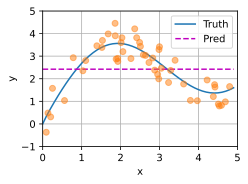

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

y_hat = d2l.repeat(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

非参数注意力汇聚

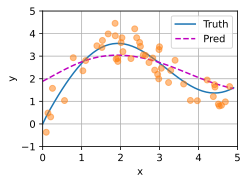

In [5]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = d2l.reshape(x_test.repeat(n_train), (-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.Softmax(axis=1)(-(X_repeat - x_train)**2 / 2)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = d2l.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

注意力权重

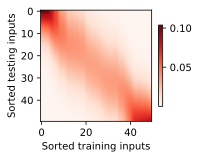

In [6]:
d2l.show_heatmaps(d2l.expand_dims(d2l.expand_dims(attention_weights, 0), 0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

带参数注意力汇聚
假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$

In [7]:
X = d2l.ones((2, 1, 4))
Y = d2l.ones((2, 4, 6))
d2l.bmm(X, Y).shape

(2, 1, 6)

使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [8]:
weights = d2l.ones((2, 10)) * 0.1
values = d2l.arange(20.0).reshape((2, 10))
d2l.bmm(d2l.expand_dims(weights, 1), d2l.expand_dims(values, -1))

Tensor(shape=[2, 1, 1], dtype=Float32, value=
[[[ 4.50000000e+00]],
 [[ 1.45000000e+01]]])

带参数的注意力汇聚

In [9]:
class NWKernelRegression(nn.Cell):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = Parameter(d2l.rand((1,)))

    def construct(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = d2l.reshape(queries.repeat(keys.shape[1]), (-1, keys.shape[1]))
        self.attention_weights = nn.Softmax(axis=1)(
            -((queries - keys) * self.w)**2 / 2)
        # values的形状为(查询个数，“键－值”对个数)
        return d2l.bmm(d2l.expand_dims(self.attention_weights, 1),
                         d2l.expand_dims(values, -1)).reshape(-1)

将训练数据集变换为键和值

In [10]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = d2l.tile(x_train, (n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = d2l.tile(y_train, (n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = d2l.reshape(X_tile[(1 - d2l.eye(n_train)).astype(mindspore.int32)],
                   (n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = d2l.reshape(Y_tile[(1 - d2l.eye(n_train)).astype(mindspore.int32)],
                     (n_train, -1))

训练带参数的注意力汇聚模型

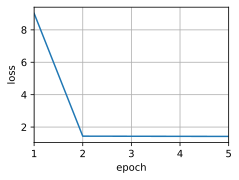

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
optimizer = nn.SGD(net.trainable_params(), 0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

def train_loop(model, data, label, loss_fn, optimizer):
    # 定义前向传播函数
    def forward_fn(data, label):
        logits = model(data[0], data[1], data[2])
        loss = loss_fn(logits, label)
        return loss

    # 获取梯度函数
    grad_fn = value_and_grad(forward_fn, None, optimizer.parameters)

    # 定义模型单步训练
    def train_one_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    return train_one_step(data, label)

for epoch in range(5):
    l = train_loop(net, (x_train, keys, values), y_train, loss, optimizer) / 2
    print(f'epoch {epoch + 1}, loss {float(l.sum().asnumpy()):.6f}')
    animator.add(epoch + 1, float(l.sum().asnumpy()))

预测结果绘制

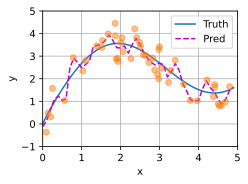

In [13]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = d2l.tile(x_train, (n_test, 1))
# value的形状:(n_test，n_train)
values = d2l.tile(y_train, (n_test, 1))
y_hat = d2l.expand_dims(net(x_test, keys, values), 1)
plot_kernel_reg(y_hat)

曲线在注意力权重较大的区域变得更不平滑

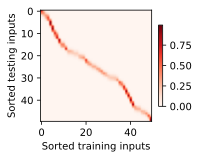

In [14]:
d2l.show_heatmaps(d2l.expand_dims(d2l.expand_dims(net.attention_weights, 0), 0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')